In [754]:
# Only these three packages are allowed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [74]:
class FLD:
    def __init__(self):
        """
            You can add/change any variables/methods to meet your need.
        """
        self.mean_vectors = None
        self.sw = None
        self.sb = None
        self.w = None
        self.slope = None

    def fit(self, X, y):
        
        class_labels = np.unique(y)
        num_features = X.shape[1]
            
        # Calculate mean vectors for each class
        self.mean_vectors = []
        for i in np.unique(y):
            self.mean_vectors.append(np.mean(X[y == i], axis=0))
        self.mean_vectors = np.array(self.mean_vectors)

        # Within-class scatter matrix
        self.sw = np.zeros((num_features, num_features))
        for label, mv in zip(class_labels, self.mean_vectors):
            class_sc_mat = np.zeros((num_features, num_features))
            for row in X[y == label]:
                row, mv = row.reshape(num_features, 1), mv.reshape(num_features, 1)
                class_sc_mat += (row - mv).dot((row - mv).T)
            self.sw += class_sc_mat

        # Between-class scatter matrix
        overall_mean = np.mean(X, axis=0)
        self.sb = np.zeros((num_features, num_features))
        for i, mean_vec in enumerate(self.mean_vectors):
            n = X[y==i,:].shape[0]
            mean_vec = mean_vec.reshape(num_features, 1)
            overall_mean = overall_mean.reshape(num_features, 1)
            self.sb += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)

        # Find the eigenvectors and eigenvalues of (sW)^-1 * sB
        eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(self.sw).dot(self.sb))
        sorted_idx = np.argsort(eig_vals)[::-1]
        eig_vals, eig_vecs = eig_vals[sorted_idx], eig_vecs[:, sorted_idx]

        # Project the data onto the subspace spanned by the top eigenvectors
        self.w = eig_vecs[:, :1]
        

    def predict_using_class_mean(self, X, y, X_test):
        
        class_labels = np.unique(y)
        mean_vectors = []
        for label in class_labels:
            mean_vectors.append(np.mean(X[y == label], axis=0))

        y_pred = []
        for x in X_test:
            distances = []
            for mv in mean_vectors:
                distances.append(np.linalg.norm(x - mv))
            y_pred.append(class_labels[np.argmin(distances)])

        return np.array(y_pred)
        

    def predict_using_knn(self, X, y, X_test, k=1):
        
        y_pred = []
        for x in X_test:
            distances = []
            for x_train in X:
                distances.append(np.linalg.norm(x - x_train))
            nearest_labels = y[np.argsort(distances)[:k]]
            y_pred.append(np.bincount(nearest_labels).argmax())

        return np.array(y_pred)

    def show_confusion_matrix(self, y, y_pred):
        
        n_classes = len(np.unique(y))
        
        cm = np.zeros((n_classes, n_classes), dtype=int)
        for i in range(y.shape[0]):
            true_class = y[i]
            pred_class = y_pred[i]
            cm[true_class][pred_class] += 1
        return cm
    
    def plot_projection(self, X, y):
        
        # X_proj = X.dot(self.w)
        # X_proj = np.dot(np.dot(X, self.w) / np.linalg.norm(self.w)**2, self.w.T)
        X_proj = (np.dot(X, self.w) * self.w.T) / np.dot(self.w.T, self.w)
        
        # y = mx+ b
        # point = (w0, w1)
        slope = self.w[1][0]/self.w[0][0] # m
        intercept = self.w[1][0] - (slope*self.w[0][0]) # b
        
        # projection line
        plt.axline(xy1=(0, intercept), slope=slope, c='black')
        
        colors = ['r', 'b', 'g']
        
        # project train data to the projection line with dashed line
        for idx, pj in enumerate(X_proj):
            if y[idx] == 0:
                c = 'r'
            elif y[idx] == 1:
                c = 'b'
            else:
                c = 'g'
            plt.plot([pj[0], X[idx, 0]], [pj[1], X[idx, 1]], ls=':', alpha=0.2, c=c)
        
        # projected point on the line
        
        # train data scatter plot
        for point, pred in zip(X, y):
            plt.scatter(point[0], point[1], color=colors[pred], alpha=1.0, s=5)
            proj = (np.dot(point, self.w) * self.w) / np.dot(self.w.T, self.w)
            plt.scatter(proj[0], proj[1], color=colors[pred], alpha=1.0, s=5)

        plt.title('Projection line: slope = %.8f, intercept = %.2f' %(slope, intercept))
        plt.xlim((-13, 4))
        plt.ylim((-12, 12))
        plt.show()
        

    def accuracy_score(self, y, y_pred):
        return np.mean(y_pred == y)

In [113]:
class MultiClassLogisticRegression:
    
    def __init__(self):
        
        self.epoch = []
        self.train_loss = []
        self.weights = None

    def fit(self, X, y, batch_size=16, lr=0.001, epochs=100):
        
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))
        self.weights = np.zeros((n_features, n_classes))
        
        for i in range(epochs):
            
            epoch_loss = 0.0
            
            for j in range(0, n_samples, batch_size):
                
                X_batch = X[j:j+batch_size]
                y_batch = y[j:j+batch_size]
                
                scores = np.dot(X_batch, self.weights)
                probs = self.softmax(scores)
                loss = self.cross_entropy(y_batch, probs)
                
                grad = np.dot(X_batch.T, probs - self.one_hot(y_batch, n_classes)) / batch_size
                self.weights -= lr * grad
                
                epoch_loss += loss
            
            self.epoch.append(i)
            self.train_loss.append(epoch_loss / n_samples)
            
        return self

    def predict(self, X):
        scores = np.dot(X, self.weights)
        return np.argmax(scores, axis=1)

    def evaluate(self, X, y):
        y_pred = self.predict(X)
        return self.accuracy_score(y, y_pred)

    def softmax(self, z):
        exp_scores = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def cross_entropy(self, y, probs):
        return -np.mean(np.log(probs[np.arange(len(y)), y]))

    def accuracy_score(self, y, y_pred):
        return np.mean(y == y_pred)

    def show_confusion_matrix(self, X, y):
        y_pred = self.predict(X)
        cm = np.zeros((len(np.unique(y)), len(np.unique(y_pred))))
        for i in range(len(y)):
            cm[y[i], y_pred[i]] += 1
        return cm
    
    def one_hot(self, y, n_classes):
        return np.eye(n_classes)[y]
    
    def plot_curve(self):
        # self.epoch and self.train_loss may be helpful here. 
        
        plt.plot(self.epoch, self.train_loss, color = 'blue', linewidth = '1', label='Train CE loss')
        plt.xlabel('epoch')
        plt.ylabel('CE Loss')
        plt.title('Training Loss')
        plt.legend()
        plt.show()

# Prepare data for Q1 ~ Q12

In [374]:
df_train = pd.DataFrame(pd.read_csv("./PR_HW2_blob_train.csv"))
df_test  = pd.DataFrame(pd.read_csv("./PR_HW2_blob_test.csv"))

In [375]:
X_train = df_train[['Feature1', 'Feature2']].to_numpy()
y_train = df_train[['Target']].to_numpy().ravel()

X_test = df_test[['Feature1', 'Feature2']].to_numpy()
y_test = df_test[['Target']].to_numpy().ravel()

print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test",  X_test.shape)
print("y_test",  y_test.shape)

X_train (1000, 2)
y_train (1000,)
X_test (1000, 2)
y_test (1000,)


# MultiClass Logistic Regression

In [975]:
x_train_norm = (X_train - np.min(X_train)) / (np.max(X_train) - np.min(X_train))
x_train_std = (X_train - np.average(X_train)) / (np.std(X_train))

x_test_norm = (X_test - np.min(X_test)) / (np.max(X_test) - np.min(X_test))
x_test_std = (X_test - np.average(X_test)) / (np.std(X_test))

In [1047]:
# For Q1
lr = 1e-05
batch_size = 1 
epoch = 8000 

logistic_reg = MultiClassLogisticRegression()
logistic_reg.fit(X_train, y_train, lr=lr, batch_size=batch_size, epochs=epoch)

In [1048]:
# For Q2
print('Training acc: ', logistic_reg.evaluate(X_train, y_train))

Training acc:  0.893


In [1049]:
# For Q3
print('Testing acc: ', logistic_reg.evaluate(X_test, y_test))

Testing acc:  0.883


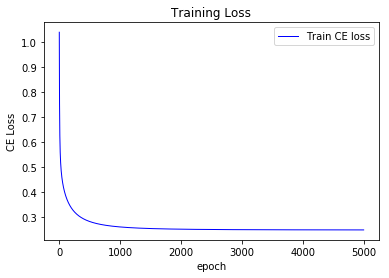

In [1050]:
# For Q4
logistic_reg.plot_curve()

In [1051]:
# For Q5
logistic_reg.show_confusion_matrix(X_test, y_test)

array([[283.,   0.,  57.],
       [  0., 333.,   0.],
       [ 60.,   0., 267.]])

# Fisher's Linear Discriminant Analysis

In [75]:
fld = FLD()

fld.fit(X_train, y_train)

In [76]:
# For Q6
print("Class mean vector: ", fld.mean_vectors)

Class mean vector:  [[-4.17505764  6.35526804]
 [-9.43385176 -4.87830741]
 [-2.54454008  7.53144179]]


In [77]:
# For Q7
print("Within-class scatter matrix SW: ", fld.sw)

Within-class scatter matrix SW:  [[1052.70745046  -12.5828441 ]
 [ -12.5828441   971.29686189]]


In [78]:
# For Q8
print("Between-class scatter matrix SB: ", fld.sb)

Between-class scatter matrix SB:  [[ 8689.12907035 16344.86572983]
 [16344.86572983 31372.93949414]]


In [79]:
# For Q9
print("W: ", fld.w)

W:  [[-0.44115384]
 [-0.8974315 ]]


In [80]:
# For Q10
y_pred = fld.predict_using_class_mean(X_train, y_train, X_test)
print("FLD using class mean, accuracy: ", fld.accuracy_score(y_test, y_pred))

fld.show_confusion_matrix(y_test, y_pred)

FLD using class mean, accuracy:  0.886


array([[286,   0,  54],
       [  0, 333,   0],
       [ 60,   0, 267]])

In [550]:
# For Q11
y_pred_k1 = fld.predict_using_knn(X_train, y_train, X_test, k=1)
print("FLD using knn (k=1), accuracy: ", fld.accuracy_score(y_test, y_pred_k1))

y_pred_k2 = fld.predict_using_knn(X_train, y_train, X_test, k=2)
print("FLD using knn (k=2), accuracy: ", fld.accuracy_score(y_test, y_pred_k2))

y_pred_k3 = fld.predict_using_knn(X_train, y_train, X_test, k=3)
print("FLD using knn (k=3), accuracy: ", fld.accuracy_score(y_test, y_pred_k3))

y_pred_k4 = fld.predict_using_knn(X_train, y_train, X_test, k=4)
print("FLD using knn (k=4), accuracy: ", fld.accuracy_score(y_test, y_pred_k4))

y_pred_k5 = fld.predict_using_knn(X_train, y_train, X_test, k=5)
print("FLD using knn (k=5), accuracy: ", fld.accuracy_score(y_test, y_pred_k5))

FLD using knn (k=1), accuracy:  0.839
FLD using knn (k=2), accuracy:  0.846
FLD using knn (k=3), accuracy:  0.878
FLD using knn (k=4), accuracy:  0.876
FLD using knn (k=5), accuracy:  0.878


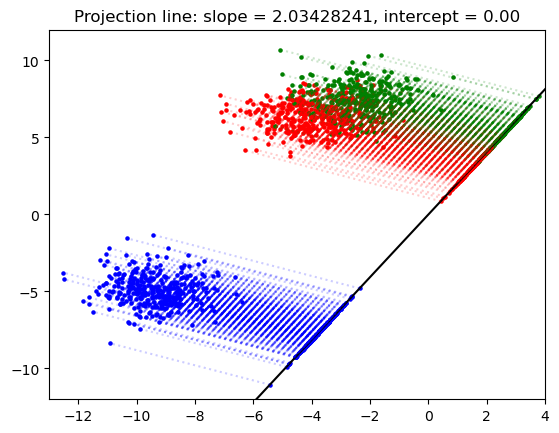

In [81]:
# For Q12, using only training data
fld.plot_projection(X_train, y_train)

# Train your own model on provided dataset.
You can only using 1) **Fisher's Linear Discriminant** or 2) **Logistic Regression** that you have implemented above.

In [161]:
class MultiClassLogisticRegression:
    
    def __init__(self):
        
        self.epoch = []
        self.train_loss = []
        self.weights = None

    def fit(self, X, y, batch_size=16, lr=0.001, epochs=100):
        
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))
        self.weights = np.zeros((n_features, n_classes))

        # shuffle the data
        shuffle_indices = np.random.permutation(len(X))
        X = X[shuffle_indices]
        y = y[shuffle_indices]
        
        for i in range(epochs):
            
            epoch_loss = 0.0
            
            for j in range(0, n_samples, batch_size):
                
                X_batch = X[j:j+batch_size]
                y_batch = y[j:j+batch_size]
                
                scores = np.dot(X_batch, self.weights)
                probs = self.softmax(scores)
                loss = self.cross_entropy(y_batch, probs)
                
                grad = np.dot(X_batch.T, probs - self.one_hot(y_batch, n_classes)) / batch_size
                self.weights -= lr * grad
                
                epoch_loss += loss
            
            self.epoch.append(i)
            self.train_loss.append(epoch_loss / n_samples)
            
        return self

    def predict(self, X):
        scores = np.dot(X, self.weights)
        return np.argmax(scores, axis=1)

    def evaluate(self, X, y):
        y_pred = self.predict(X)
        return self.accuracy_score(y, y_pred)

    def softmax(self, z):
        exp_scores = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def cross_entropy(self, y, probs):
        return -np.mean(np.log(probs[np.arange(len(y)), y]))

    def accuracy_score(self, y, y_pred):
        return np.mean(y == y_pred)

    def show_confusion_matrix(self, X, y):
        y_pred = self.predict(X)
        cm = np.zeros((len(np.unique(y)), len(np.unique(y_pred))))
        for i in range(len(y)):
            cm[y[i], y_pred[i]] += 1
        return cm
    
    def one_hot(self, y, n_classes):
        return np.eye(n_classes)[y]
    
    def plot_curve(self):
        # self.epoch and self.train_loss may be helpful here. 
        
        plt.plot(self.epoch, self.train_loss, color = 'blue', linewidth = '1', label='Train CE loss')
        plt.xlabel('epoch')
        plt.ylabel('CE Loss')
        plt.title('Training Loss')
        plt.legend()
        plt.show()

In [135]:
df_train = pd.DataFrame(pd.read_csv("./PR_HW2_train.csv"))
df_val   = pd.DataFrame(pd.read_csv("./PR_HW2_val.csv"))
df_test  = pd.DataFrame(pd.read_csv("./PR_HW2_test.csv"))

In [136]:
df_train.head()

,Feature1,Feature2,Feature3,Feature4,Target
0,0.00668,0.00192,0.682,0.996,2.0
1,0.00680,0.00106,0.503,0.996,1.0
2,0.00742,0.00106,0.482,0.991,1.0
3,0.00685,0.00178,0.650,0.998,2.0
4,0.00680,0.00163,0.623,0.996,2.0


In [137]:
df_test.head()

,Feature1,Feature2,Feature3,Feature4,Target
0,0.00699,0.000877,0.451,0.994,NaN
1,0.00736,0.001370,0.549,0.998,NaN
2,0.00687,0.001420,0.580,0.992,NaN
3,0.00752,0.002520,0.737,0.996,NaN
4,0.00685,0.000910,0.464,0.992,NaN


In [162]:
# Data processing

# Refer to section "Prepare data for Q1 ~ Q12"

# Downsampling
typicalNDict = {0.0: 738, 1.0: 738, 2.0: 738}
 
def typicalsamling(group, typicalNDict):
    name = group.name
    n = typicalNDict[name]
    return group.sample(n=n, replace=True, random_state=0)

result = df_train.groupby('Target').apply(typicalsamling, typicalNDict)
print(result.head())


             Feature1  Feature2  Feature3  Feature4  Target
Target                                                     
0.0    1556   0.00768   0.00224     0.688     0.999     0.0
       1308   0.00785   0.00246     0.713     0.997     0.0
       1441   0.00741   0.00175     0.619     0.993     0.0
       467    0.00735   0.00211     0.682     0.998     0.0
       1620   0.00881   0.00198     0.604     0.994     0.0


In [163]:
X_train = result[['Feature1', 'Feature2', 'Feature3', 'Feature4']].to_numpy()
y_train = result[['Target']].to_numpy().ravel()
y_train = np.int32(y_train)

X_val = df_val[['Feature1', 'Feature2', 'Feature3', 'Feature4']].to_numpy()
y_val = df_val[['Target']].to_numpy().ravel()
y_val = np.int32(y_val)

X_test = df_test[['Feature1', 'Feature2', 'Feature3', 'Feature4']].to_numpy()
y_test = df_test[['Target']].to_numpy().ravel()
y_test = np.int32(y_test)

print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_val",  X_val.shape)
print("y_val",  y_val.shape)
print("X_test",  X_test.shape)
print("y_test",  y_test.shape)

X_train (2214, 4)
y_train (2214,)
X_val (730, 4)
y_val (730,)
X_test (5677, 4)
y_test (5677,)


In [164]:
x_train_norm = (X_train - np.min(X_train)) / (np.max(X_train) - np.min(X_train))
x_train_std = (X_train - np.average(X_train)) / (np.std(X_train))

x_val_norm = (X_val - np.min(X_val)) / (np.max(X_val) - np.min(X_val))
x_val_std = (X_val - np.average(X_val)) / (np.std(X_val))

x_test_norm = (X_test - np.min(X_test)) / (np.max(X_test) - np.min(X_test))
x_test_std = (X_test - np.average(X_test)) / (np.std(X_test))

In [165]:
# Train your model here

lr = 0.5
batch_size = 1
epoch = 60000

model = MultiClassLogisticRegression()
model.fit(x_train_norm, y_train, lr=lr, batch_size=batch_size, epochs=epoch)

In [166]:
print('Training acc: ', model.evaluate(x_train_norm, y_train))

Training acc:  0.8934056007226739


In [167]:
print('Validation acc: ', model.evaluate(x_val_norm, y_val))  # lr=0.5, epoch=60000 -> 0.9(X_train)

Validation acc:  0.9


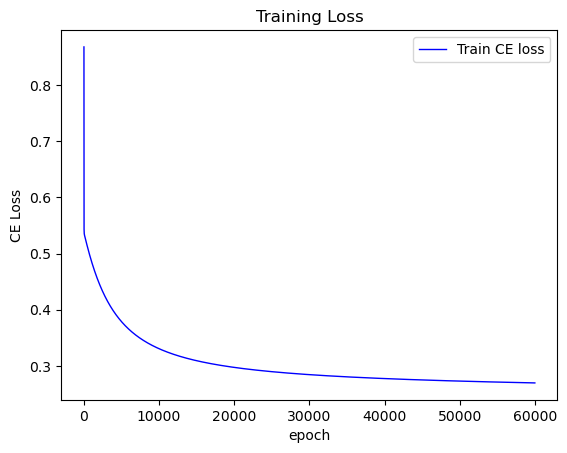

In [168]:
model.plot_curve()

In [169]:
model.show_confusion_matrix(x_val_norm, y_val)

array([[281.,   3.,  45.],
       [  0., 144.,   6.],
       [ 14.,   5., 232.]])

In [170]:
test_pred = model.predict(x_test_norm)
print("test_pred shape: ", test_pred.shape)

test_pred shape:  (5677,)


# Output the csv file

In [171]:
# For Q13
df_test = pd.DataFrame(pd.read_csv("./PR_HW2_test.csv"))
df_test["Target"] = test_pred
df_test.to_csv("311553009_prediction.csv")